# Cesta do útrob rozhodovacího stromu

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

Na úplně prvním běhu tohoto kurzu jsem vznesla požadavek "nakresli mi rozhodovací strom". Roman pohotově vymyslel následující úložku. Máme sadu vozidel, u kterých známe váhu a počet kol. Úkolem je vytvořit rozhodovací strom, který bude rozhodovat, zda je na vozidlo potřeba řidičský průkaz nebo není. 

Na této jednoduché úloze si budeme demonstrovat, jak rozhodovací strom funguje a co všechno z něj lze vyčíst. 

Začneme tím, že si vytvoříme jednoduchý DataFrame obsahující náš vozový park:

In [2]:
vozidla = [
    {"jmeno": "jednokolka", "vaha": 20, "kola": 1, "ridicak": False},
    {"jmeno": "tříkolka", "vaha": 10, "kola": 3, "ridicak": False},
    {"jmeno": "odrážedlo", "vaha": 5, "kola": 4, "ridicak": False},
    {"jmeno": "inline brusle", "vaha": 1, "kola": 8, "ridicak": False},
    {"jmeno": "vyložený paleťák", "vaha": 140, "kola": 8, "ridicak": False},
    {"jmeno": "naložený paleťák", "vaha": 1140, "kola": 8, "ridicak": False},
    {"jmeno": "auto", "vaha": 2000, "kola": 4, "ridicak": True},
    {"jmeno": "velorex", "vaha": 365, "kola": 3, "ridicak": True},
    {"jmeno": "motorka", "vaha": 200, "kola": 2, "ridicak": True},
    {"jmeno": "autobus", "vaha": 18000, "kola": 8, "ridicak": True}
]

df = pd.DataFrame(vozidla)
df

,jmeno,vaha,kola,ridicak
0,jednokolka,20,1,False
1,tříkolka,10,3,False
2,odrážedlo,5,4,False
3,inline brusle,1,8,False
4,vyložený paleťák,140,8,False
5,naložený paleťák,1140,8,False
6,auto,2000,4,True
7,velorex,365,3,True
8,motorka,200,2,True
9,autobus,18000,8,True


Nyní si data zobrazíme, na váhy bude lepší použít logaritmické měřítko. 

### Úkol 1:
Prohlédněte si obrázek a zamyslete se, jak byste data odělili sadou rovných čar. Máte možnost kreslit pouze čáry kolmé na osu x nebo na osu y, tedy např. oddělující vozidla s méně než třemi koly od vozidel s více než třemi koly, apod. 

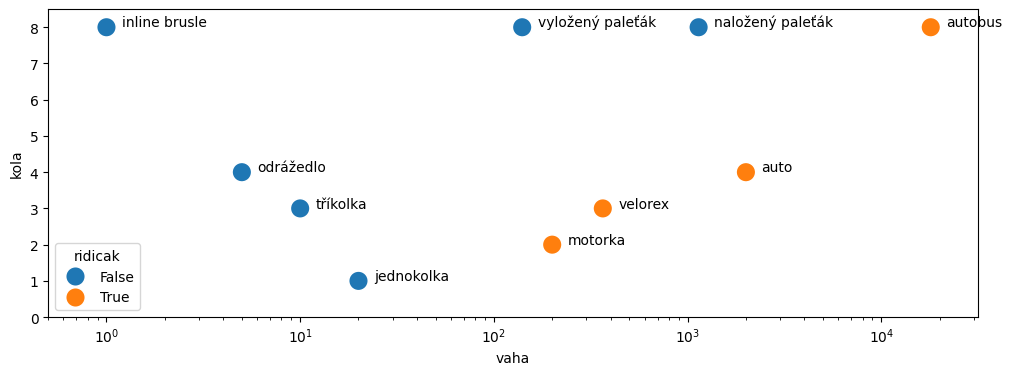

In [3]:
def show_vozovy_park(df, ax):
    ax = sns.scatterplot(data=df, x="vaha", y="kola", hue="ridicak",
                         s=200,
                         ax=ax)
    ax.set(xscale='log')
    ax.set(ylim=(0,8.5))
    ax.set(xlim=(0.5, 10**4.5))
    
    for i, row in df.iterrows():
        ax.text(1.2*row['vaha'], row['kola']+0.02, row['jmeno'])
    return ax
    
f, ax = plt.subplots(figsize=(12,4))
show_vozovy_park(df, ax);    

Nyní vytvořme rozhodovací strom pomocí Sciki-learn třídy [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). 

In [4]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [5]:
input_features = ["vaha", "kola"]
output_feature = "ridicak"
classes = ["Řidičák netřeba",  "Řidičák nutný"] #False ... bez řidičáku, True s řidičákem

In [6]:
y = df[output_feature]
X = df[input_features]

Pozn.: Tentokrát neřešíme trénovací a testovací data, jde jen o ilustrační úlohu.

In [7]:
tree = DecisionTreeClassifier()
tree.fit(X, y)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


Použijeme pomocnou funkci [plot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html) a můžeme si strom prohlédnout:

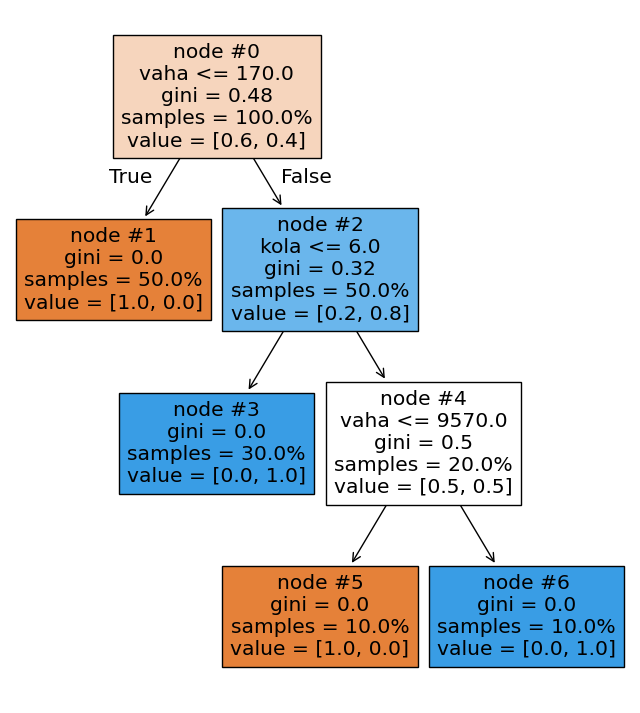

<Figure size 1200x400 with 0 Axes>

In [8]:
_, ax = plt.subplots(figsize=(8, 9))
plt.figure(figsize=(12,4))
plot_tree(tree, proportion=True, filled=True, node_ids=True, feature_names=["vaha", "kola"], ax=ax);

Teď si z původního DataFramu vyzobneme jeden řádek, třeba ten pro autobus:

In [9]:
to_classify = df.loc[df["jmeno"] == "autobus"]
to_classify

,jmeno,vaha,kola,ridicak
9,autobus,18000,8,True


Teď využijeme metodu stromu `decision_path`, které předáme náš vstup (`input_sample`), tedy váhu a počet kol autobusu, a která nám vrátí pole nul a jedniček stejné délky jako je počet uzlů stromu. Uzly, které mají indikátor 1 jsou navštíveny při cestě stromem, přes uzly které mají indicátor 0 náš autobus neprochází.

In [10]:
input_sample = to_classify[input_features] 
node_indicators = tree.decision_path(input_sample).toarray()[0]
node_indicators

array([1, 0, 1, 0, 1, 0, 1])

Vyzobněme si čísla uzlů, které mají hodnotu indikátoru 1 a vypišme si cestu stromem:

In [11]:
node_ids = [i for i, indicator in enumerate(node_indicators) if indicator]

print(" --> ".join(map(lambda x: f"#{x}", node_ids)))

#0 --> #2 --> #4 --> #6


Autobus tedy začíná v uzlu 0, který je vrcholem stromu a postupně postupuje stromem dle rozhodovacích podmínek v uzlech až skončí v uzlu č. 6, který je listem stromu a obsahuje výslednou klasifikaci.

Číslo listu, kde vzorek skončí, můžeme také získat pomocí metody apply:

In [12]:
leaf_id = tree.apply(input_sample)
# metoda bere na vstup více vzorů (matice N x počet vstupů) a vrací číslo listu pro každý z těchto vzorů  (vektor N čísel)
# v našem případě jsme předali jeden vstupní vzorek, musíme tedy vyzobnout první číslo
leaf_id[0] 

np.int64(6)

Teď si vypišme podrobněji cestu našeho autobusu stromem: 

In [13]:
print(f"Pravidla pro predikci vzorku '{to_classify.iloc[0]['jmeno']}':\n")

feature = tree.tree_.feature # index vstupní proměnné, která se používá v daném uzlu při rozhodování kam dál 
threshold = tree.tree_.threshold # threshold daného uzlu 
values = tree.tree_.value # pro každý uzel pole výstupů pro každou třídu 

for node_id in node_ids:
    if  leaf_id == node_id:
        print(f"output node   #{node_id}: ".ljust(50), end=" ") 
    else: 
        if input_sample.iloc[0, feature[node_id]] <= threshold[node_id]:
            threshold_sign = "<="
        else:
            threshold_sign = ">"

        print((f"decision node #{node_id} : ({input_sample.columns[feature[node_id]]} = {input_sample.iloc[0, feature[node_id]]}) " + 
              f"{threshold_sign} {threshold[node_id]}").ljust(50), end=" ")
    print(f"{classes[0]}: {100*values[node_id][0][0]:3.0f}%, {classes[1]}: {100*values[node_id][0][1]:3.0f}%")
print()

Pravidla pro predikci vzorku 'autobus':

decision node #0 : (vaha = 18000) > 170.0          Řidičák netřeba:  60%, Řidičák nutný:  40%
decision node #2 : (kola = 8) > 6.0                Řidičák netřeba:  20%, Řidičák nutný:  80%
decision node #4 : (vaha = 18000) > 9570.0         Řidičák netřeba:  50%, Řidičák nutný:  50%
output node   #6:                                  Řidičák netřeba:   0%, Řidičák nutný: 100%



### Úkol 2: 
Vraťte se k buňce, kde definujeme jednořádkový DataFrame `to_classify` a zkuste vybrat jiné vozidlo. Pak se podívejte, jak toto vozidlo putuje rozhodovacím stromem.

Na závěr si ještě prohlédneme, jak vypadá vstupní prostor a rozhodovací hranice v něm. Použijeme barevnou paletu `plt.cm.coolwarm`, tedy záporná čísla nám půjdou do studených barev (modrá) a kladná čísla do teplých barev (červená). Červená nám tedy indikuje potřebu řidičáku.

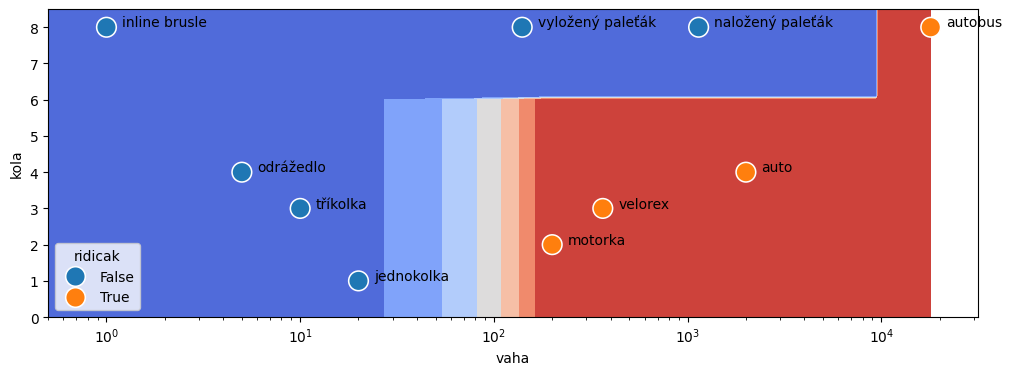

In [14]:
from sklearn.inspection import DecisionBoundaryDisplay
f, ax = plt.subplots(figsize=(12,4))
def show_decision_boundary(model, X, ax):
    DecisionBoundaryDisplay.from_estimator(
        model,
        X,
        cmap=plt.cm.coolwarm,
        response_method="predict",
        xlabel="vaha",
        ylabel="kola",
        eps=1,
        ax=ax,
    )
    ax = show_vozovy_park(df, ax)
    return ax
ax = show_decision_boundary(tree, X, ax)

### Úkol 3: 
Na obrázku máme třídy oddělené schodovitou čarou. Dovedli byste třídy oddělit jednou čarou? Nemusí být tentokrát kolmá na osu. 

# Lineární klasifikace

Na obrázku nahoře lze oddělit vozidla bez řídičáku a vozidla se řidičákem rovnou čarou. Klasifikaci proto můžeme zvládnout i lineárním modelem, jen pozor potřebujeme logaritmus váhy, protože na obrázku máme logaritmické měřítko.

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer

Vytvoříme si transformátor, který nám sloupeček váha převede na logaritmus. Ostatní sloupečky nechá jak jsou. Pro jednoduchost a snadné zobrazování nebudeme data škálovat.

In [16]:
import numpy as np
vaha_to_log = make_column_transformer(
    (FunctionTransformer(np.log), ["vaha"]),
    remainder="passthrough"
)

Transformátor spolu s lineární regresí spojíme do jednoho modelu pomocí `pipeline`.

In [17]:
model = Pipeline([("transform", vaha_to_log),  ("model", LinearRegression())])
model.fit(X, y)

,steps,"[('transform', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('functiontransformer', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [18]:
pred = model.predict(X)
pred

array([ 0.43319275,  0.20806847,  0.05020376, -0.42921315,  0.21673647,
        0.49086547,  0.83338148,  0.6782932 ,  0.66691691,  0.85155464])

Model se učil na datech, kde `False` neboli `0` znamenalo, že řidičák není potřeba, a `True` neboli `1` znamenalo, že řidičák potřeba je. Regrese nám bude vracet hodnoty typu `float`, které můžeme interpretovat tak, že menší než `0.5` znamenají nulu, neboli *bez řidičáku*, a větší než `0.5` znamenají jedničku, neboli *řidičák je potřeba*.

In [19]:
df["predikce"] = pred > 0.5
df

,jmeno,vaha,kola,ridicak,predikce
0,jednokolka,20,1,False,False
1,tříkolka,10,3,False,False
2,odrážedlo,5,4,False,False
3,inline brusle,1,8,False,False
4,vyložený paleťák,140,8,False,False
5,naložený paleťák,1140,8,False,False
6,auto,2000,4,True,True
7,velorex,365,3,True,True
8,motorka,200,2,True,True
9,autobus,18000,8,True,True


Na tabulce vidíme, že regrese zvládá oddělit vozidla s řidičákem a bez. Ještě si vykresleme, jak vypadá z pohledu regrese vstupní prostor. Naložený paleťák má namále, ale všechna vozidla jsou správně oddělena.

Kromě barevné mapy si vykreslíme i čáru, zobrazující hranici tříd, tedy přímku, kde lineární regrese dává výstup `0.5`. Linární regrese počítá lineární kombinaci svých vstupů, tedy:
$$ y = w_0 \cdot V_{log} + w_1 \cdot K + b $$, 
kde $V_{log}$ je logaritmus váhy vozidla, $K$ je počet kol a $w_0, w_1, b$ jsou parametry modelu.  Abychom do grafu mohli vykreslit dělící přímku, vyjádřeme si závislost váhy na počtu kol pro $y = 0.5$:
$$
 V_{log} = (0.5 - w_1 \cdot K - b) / w_0.
$$
Pomocí tohoto vzorečku si můžeme nagenerovat data pro vykreslení přímky odpovídající hranici.

In [20]:
# decision boundary display aplikovaný na celou pipeline zkresluje hranice kvůli logaritmickému měřítku a malému rozlišení
# pro větší rozlišení se to seká, logaritmické rozlišení asi neexistuje :)
# tak to obejdeme ...

In [21]:
df["vaha_log"] = np.log(df["vaha"])
X_plot = df[["vaha_log", "kola"]]
linear_model = model.named_steps["model"]
linear_model

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


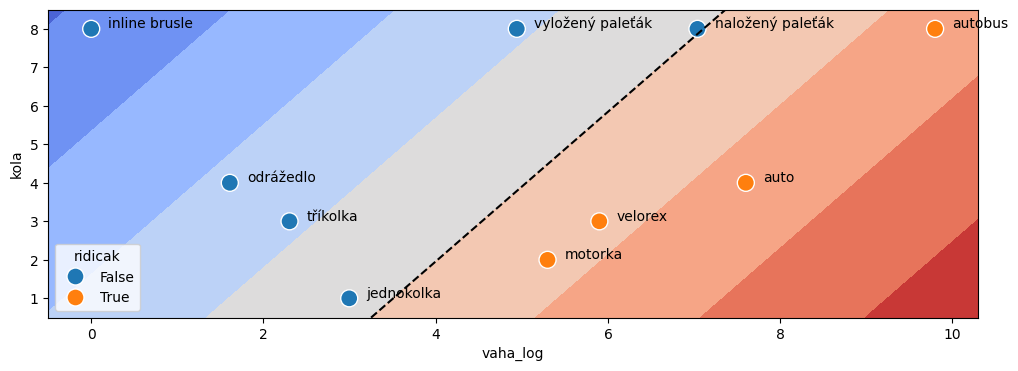

In [22]:
f, ax = plt.subplots(figsize=(12, 4))
DecisionBoundaryDisplay.from_estimator(
        linear_model,
        X_plot.values,
        cmap=plt.cm.coolwarm,
        response_method="predict",
        xlabel="vaha_log",
        ylabel="kola",
        eps=0.5, ax=ax)
sns.scatterplot(data=df, x="vaha_log", y="kola", hue="ridicak", s=150)
for i, row in df.iterrows():
        ax.text(row['vaha_log']+0.2, row['kola']+0.02, row['jmeno']);


# Vykreslíme i hranici, kde lineární regrese dává na výstup přesně 0.5 
# koeficienty regrese
w = linear_model.coef_        
b = linear_model.intercept_  

# w_0 * vaha_log + w_1 * kola + b = 0.5 --> vaha_log = (0.5 - w_1 * kola - b) / w_0

y_vals = np.linspace(0.5, 8.5, 100)
# spočti y pro hranici (predikce = 0)
x_vals = (0.5 - w[1] * y_vals - b) / w[0]

# Plot
ax.plot(x_vals, y_vals, 'k--', label='Decision boundary (y=0)');


# Bonus: Nelineární problém

Pokud budeme mít data, kde nefunguje lineární klasifikace ani např. rozhodovací strom, můžeme sáhnout po modelech SVM (*Support Vector Machine*).

In [23]:
df = pd.read_csv("2sp.txt", sep=r'\s+', header=None)
df.columns = ["x1", "x2", "class"]
df.sample(10)

,x1,x2,class
17,-6.00000,-0.00478,0.0
21,-5.43003,2.24286,0.0
14,5.94519,1.18688,1.0
134,1.27190,1.93130,1.0
166,-0.72014,-1.09729,1.0
127,0.51567,-2.51008,0.0
152,1.24676,-1.22804,1.0
56,-3.36811,3.34938,1.0
30,1.09333,-5.45399,1.0
138,1.81045,1.22777,1.0


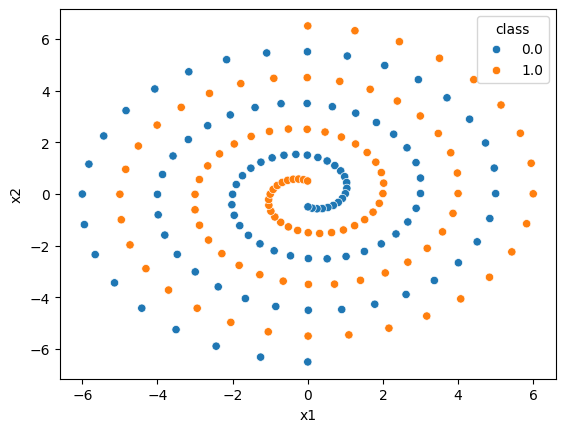

In [24]:
sns.scatterplot(data=df, x="x1", y="x2", hue="class");

In [25]:
X = df[["x1", "x2"]]
y = df["class"]

In [26]:
model1 = DecisionTreeClassifier().fit(X, y)

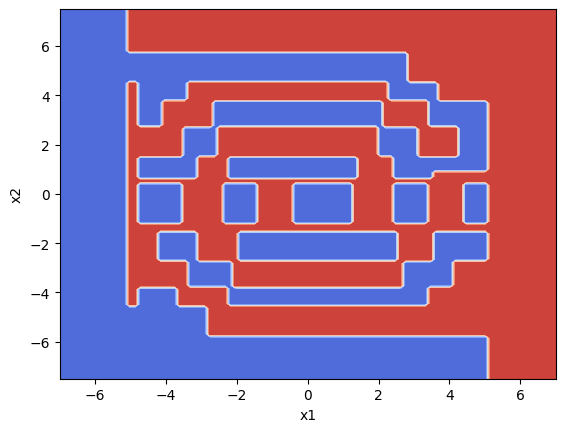

In [27]:
DecisionBoundaryDisplay.from_estimator(
    model1,
    X,
    cmap=plt.cm.coolwarm,
    response_method="predict");

In [28]:
from sklearn.svm import SVR
model2 = SVR(kernel="rbf", gamma=0.8, C=1.0).fit(X, y)
model2

,kernel,'rbf'
,degree,3
,gamma,0.8
,coef0,0.0
,tol,0.001
,C,1.0
,epsilon,0.1
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


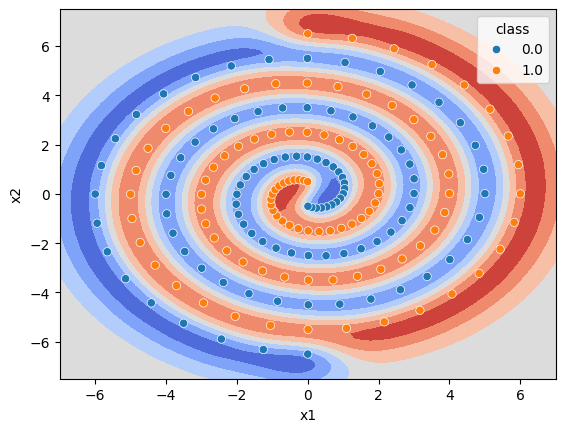

In [29]:
fig, ax = plt.subplots() 
DecisionBoundaryDisplay.from_estimator(
    model2,
    X,
    cmap=plt.cm.coolwarm,
    response_method="predict", ax=ax);
sns.scatterplot(data=df, x="x1", y="x2", hue="class", ax=ax);

# Regularizační parametr C

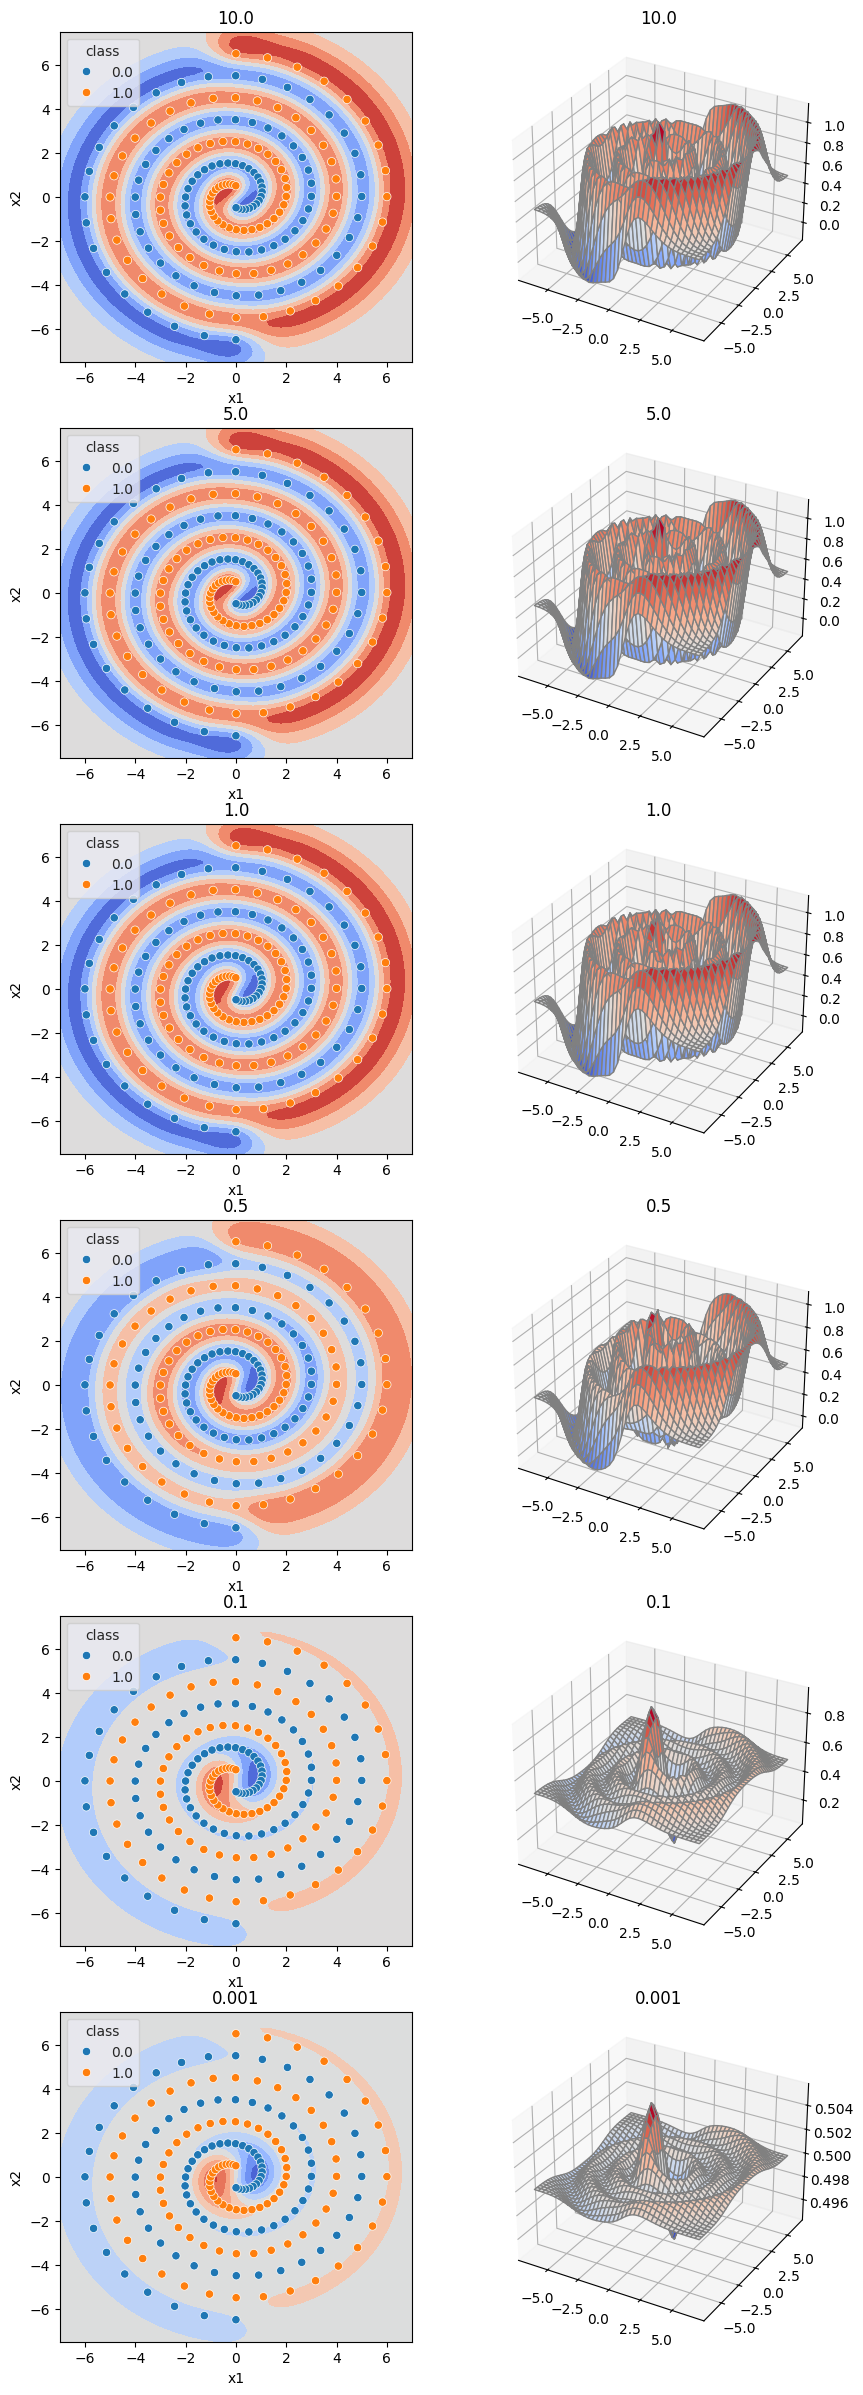

In [30]:
def plot(model, ax, C):
    sns.set_style('darkgrid')
    x_plot1 = np.linspace(-6.5, 6.5, 40)
    y_plot1 = np.linspace(-6.5, 6.5, 40)

    def comp(x1, x2):
        input_batch = pd.DataFrame()
        input_batch["x1"] = x1.ravel()
        input_batch["x2"] = x2.ravel()
        return model2.predict(input_batch).reshape(40, 40)

    plot1, plot2 = np.meshgrid(x_plot1, y_plot1)
    plot3 = comp(plot1, plot2)

    ax.plot_surface(plot1, plot2, plot3, cmap=plt.cm.coolwarm, edgecolor='gray');
    ax.set_title(f"{C}");

def plot2(model, X, ax, C):
    DecisionBoundaryDisplay.from_estimator(
        model,
        X,
        cmap=plt.cm.coolwarm,
        response_method="predict", ax=ax);
    sns.scatterplot(data=df, x="x1", y="x2", hue="class", ax=ax);
    ax.set_title(f"{C}");
  
fig  = plt.figure(figsize=(10, 30)) 
axs = [[] for _ in range(6)]
axs[0].append(fig.add_subplot(6, 2, 1))
axs[0].append(fig.add_subplot(6, 2, 2, projection='3d'))
axs[1].append(fig.add_subplot(6, 2, 3))
axs[1].append(fig.add_subplot(6, 2, 4, projection='3d'))
axs[2].append(fig.add_subplot(6, 2, 5))
axs[2].append(fig.add_subplot(6, 2, 6, projection='3d'))
axs[3].append(fig.add_subplot(6, 2, 7))
axs[3].append(fig.add_subplot(6, 2, 8, projection='3d'))
axs[4].append(fig.add_subplot(6, 2, 9))
axs[4].append(fig.add_subplot(6, 2, 10, projection='3d'))
axs[5].append(fig.add_subplot(6, 2, 11))
axs[5].append(fig.add_subplot(6, 2, 12, projection='3d'))

for i, C in enumerate([10.0, 5.0, 1.0, 0.5, 0.1, 0.001]): 
    model2 = SVR(kernel="rbf", gamma=0.8, C=C).fit(X, y)
    plot(model2, axs[i][1], C)
    plot2(model2, X, axs[i][0], C)
